In [1]:
# pip install torch_geometric

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import copy
from scipy.spatial.distance import cdist
from Ant import Ant
from ultis import *
from Cross_Exchange import *
from IBSO import *
from Injection import *
from Load_data import *
from Local_search import *
from Draw import *
from Model.AMO import *
from Normalize_data import *
import torch

In [3]:
device = None
cfg = Data_100()

EPS = 1e-10
model = Net3().to(device)
model.load_state_dict(torch.load('AMO_ACO_{}.pt'.format(cfg.graph_size), map_location=torch.device('cpu')))
model.to(device)


pyg_data_normalize = normalize_data(cfg)
heuristic_measure, log, topk = model(pyg_data_normalize)
heuristic_measure = heuristic_measure.reshape((cfg.graph_size+1, cfg.graph_size+1))

In [4]:
max_cap, xcoord, ycoord, demand, e_time, l_time, s_time, data = load_data()

CAP=max_cap
colony=Ant(data,CAP,0.7, heuristic_measure)
colony.customer_cord()
colony.euclidean_distance()
colony.width_window()
colony.path_pheromon()
result = 10000
min_prob_local = 0.005
max_prob_local = 0.01
p_local_search = 0.7
max_iteration = 100
k=0
current = 0
BTNT = []
cnt = 0
alpha = 1
candidate_route = []
pop_size = 50
n_customer = len(data)
for k in range(max_iteration):
    current_best = 10000
    final = []
    final_travel = []
    population = []
    
    for j in range(pop_size):
        min_path = 100
        index = 999
    
        colony.travel_distance = 0
        ants_travels={}
        ants_route={}
        travels=[]
        travels_2 = []
        path=[1]
        i=0
        colony.visited_list = [1]
        while True:
            colony.make_candidate_list()
            colony.choose_next_node()
            colony.move()
            path.append(colony.next_node)
            travel=colony.travel
            travels.append(travel)
            if travel[1]==1:
                if travel==(1,1):
                    break
                else:
                    ants_travels[i]=travels
                    ants_route[i]=path
                    if len(path) < min_path:
                        min_path = len(path)
                        index = i
                        
                    path=[1]
                    travels=[]
                    i=i+1
                    colony.current_point=1
                    colony.capacity=CAP
                    colony.service_time=0
            travel=colony.travel
            travels_2.append(travel)
        

        travel_distance, ants_route = injection(ants_route, colony, 0.3)
        while travel_distance < colony.travel_distance:
            colony.travel_distance = travel_distance
            travel_distance, ants_route = injection(ants_route, colony, 0.3)
        colony.travel_distance = travel_distance

        travel_distance, ants_route = cross_exchange(ants_route, colony)
        colony.travel_distance = travel_distance
        
        if np.random.random() < min_prob_local + (max_prob_local - min_prob_local)*(k/(max_iteration-1)):
            # print("Ok")
            travel_distance, ants_route = local_search(ants_route, colony, n_customer)
            colony.travel_distance = travel_distance
        

        travels_2 = split_route(ants_route)
       
        
        if colony.travel_distance < result:
            if candidate_route != [] and k > 0:
                colony.update_BTNT(split_route(candidate_route), candidate_distance, alpha, pop_size)
            alpha = 1
            result = colony.travel_distance
            best_ant_travel = travels_2
            final_route = ants_route
            candidate_route = final_route.copy()
            BTNT.append((candidate_route, colony.travel_distance))
            print(result)

        if colony.travel_distance < current_best:
            current_best = colony.travel_distance
            current_best_route = travels_2

        population.append(ants_route)
        final.append(travels_2)
        final_travel.append(colony.travel_distance)
    population, final_travel = IBSO(population, final_travel, colony, CAP, heuristic_measure)

    
    candidate_distance, candidate_route = local_search(candidate_route, colony, n_customer)
    candidate_distance, candidate_route = injection(candidate_route, colony, 0.3)

    if candidate_distance < BTNT[-1][-1]:
        cnt = 0
        alpha += 1
        BTNT.append((candidate_route, candidate_distance))
    else:
        if cnt < 2:
            alpha += 1
            candidate_distance, candidate_route = local_search(candidate_route, colony, n_customer)
            candidate_distance, candidate_route = injection(candidate_route, colony, 0.3)
            cnt += 1
        else:
            cnt = 0

            colony.update_BTNT(split_route(candidate_route), candidate_distance, alpha, pop_size)
            alpha = 1
            o = np.argsort(np.array(final_travel))[0]
            candidate_route = population[o]
            BTNT.append((candidate_route, final_travel[o]))


    

    final = []
    for i in population:
        final.append(split_route(i))

    colony.update_rho()
    # for value in colony.pheromon.values():
    #     value *= (1-colony.rho)
    for h, l in enumerate(final):  
        colony.update_pheromon(l, final_travel[h])
    colony.update_global(current_best_route, current_best)
    print('Epoch {}, BTNT: {}'.format(k, BTNT[-1][-1]))
                    



1967.5307251358352
1745.2611299719474
1704.0121955553232
1543.4550027880573
1523.373706377772
Epoch 0, BTNT: 1022.6016123476014
1169.3829101096446


KeyboardInterrupt: 

In [ ]:
ants_route, travel_distance = BTNT[np.argsort(np.array([x[1] for x in BTNT]))[0]]
travel_distance_1, ants_route = injection(ants_route, colony, 0.3)
while travel_distance_1 < travel_distance:
    travel_distance = travel_distance_1
    travel_distance_1, ants_route = injection(ants_route, colony, 0.3)

print(travel_distance)

1042.3894120066693


In [ ]:
import json 
json_data = json.dumps(ants_route, indent=0)

with open('Solution.txt', 'a') as file:
    file.write(json_data + '\n')

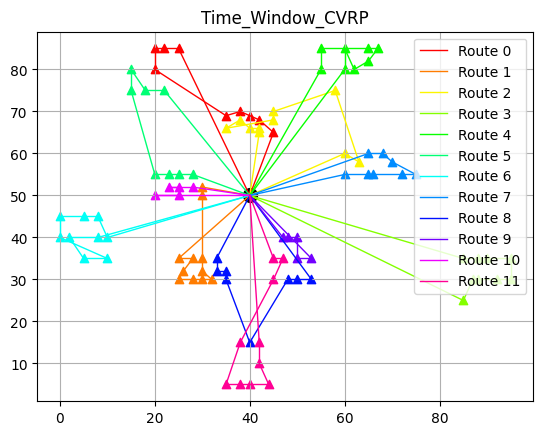

In [ ]:
draw(ants_route, colony)